# Causal Inference
## Задание CI.3


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

---


**Баллы за задание:**

* Задача 1 — 60 баллов
* Задача 2 — 120 баллов


In [76]:
# Bot check

# HW_ID: ds_ci3
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [77]:
import warnings
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import scipy.stats as sps

from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import graphviz as gr
from sklearn.metrics import mean_absolute_percentage_error as mape

from sklearn.linear_model import LogisticRegression, LinearRegression

from dowhy import CausalModel
from tqdm.notebook import tqdm
from itertools import product
from sklearn.utils import resample

from statsmodels.stats.proportion import proportion_confint
from collections import defaultdict

warnings.filterwarnings("ignore")
np.random.seed(88)
sns.set(font_scale=1.3, palette="Set2", style="whitegrid")

---
### Задача 1.

Рассмотрим оценку с двойной надежностью (DRE, doubly robust estimation). Как мы знаем, для состоятельности оценки достаточно состоятельности оценки propensity score или оценок контрафактивных исходов. Тем не менее, мы не знаем, насколько DRE устойчива в случае если обе составляющие допускают небольшое смещение. Проверим это.

Сгенерируйте искусственные данные с тритментом, таргетом и несколькими конфаундерами, причем эффект должен быть ненулевым, так мы будем знать истинное значение эффекта. Для генерации можно взять функцию из ноутбука по валидации с CI.

In [78]:
def generate_data(
    effect=0,
    sample_size=1000,
    n_confounders=1,
    n_instruments=0,
    n_covariates=1,
    w_t_coefs=None,
    w_y_coefs=None,
    z_t_coefs=None,
    x_y_coefs=None,
):
    """
    Генерирует DataFrame с колонками:
      - y           — таргет
      - T           — бинарный тритмент
      - W_0..W_{n_confounders-1} — конфаундеры
      - Z_0..Z_{n_instruments-1} — инструменты
      - X_0..X_{n_covariates-1}  — ковариаты
    """
    # 1) Подготовим коэффициенты
    if n_confounders > 0:
        locs_w = np.random.uniform(-1, 1, size=n_confounders)
        w_t_coefs = (np.full(n_confounders, 0.01)
                     if w_t_coefs is None else np.array(w_t_coefs))
        w_y_coefs = (np.full(n_confounders, 1.0)
                     if w_y_coefs is None else np.array(w_y_coefs))
    if n_instruments > 0:
        locs_z = np.random.uniform(-1, 1, size=n_instruments)
        z_t_coefs = (np.full(n_instruments, 0.01)
                     if z_t_coefs is None else np.array(z_t_coefs))
    if n_covariates > 0:
        locs_x = np.random.uniform(-1, 1, size=n_covariates)
        x_y_coefs = (np.full(n_covariates, 1.0)
                     if x_y_coefs is None else np.array(x_y_coefs))

    # 2) Заведём названия колонок и пустой DataFrame
    cols = ["y", "T"] \
           + [f"W_{i}" for i in range(n_confounders)] \
           + [f"Z_{i}" for i in range(n_instruments)] \
           + [f"X_{i}" for i in range(n_covariates)]
    data = pd.DataFrame(index=np.arange(sample_size), columns=cols)

    # 3) Генерируем смещение p_bias и loc_bias
    p_bias = np.zeros(sample_size)
    loc_bias = np.zeros(sample_size)

    # 3.1 Конфаундеры
    for i in range(n_confounders):
        w = np.random.normal(locs_w[i], scale=1.0, size=sample_size)
        data[f"W_{i}"] = w
        p_bias   += w_t_coefs[i] * w
        loc_bias += w_y_coefs[i] * w

    # 3.2 Инструменты
    for i in range(n_instruments):
        z = np.random.normal(locs_z[i], scale=1.0, size=sample_size)
        data[f"Z_{i}"] = z
        p_bias += z_t_coefs[i] * z

    # 3.3 Ковариаты
    for i in range(n_covariates):
        x = np.random.normal(locs_x[i], scale=1.0, size=sample_size)
        data[f"X_{i}"] = x
        loc_bias += x_y_coefs[i] * x

    # 4) Собираем тритмент
    p = np.clip(0.5 + p_bias, 0, 1)                     # вероятность
    t = np.random.binomial(1, p, size=sample_size)      # 0/1
    data["T"] = t

    # 5) Генерируем таргет с учётом истинного эффекта
    loc = loc_bias + effect * t
    y = np.random.normal(loc, scale=1.0, size=sample_size)
    data["y"] = y

    return data

In [79]:
effect = 0.5
sample_size = 1000

data = generate_data(
    effect=effect,
    sample_size=sample_size,
    n_confounders=2,
    n_instruments=0,
    n_covariates=1,
)
data.head()

,y,T,W_0,W_1,X_0
0,1.205280,0,0.605984,-0.373046,-0.271420
1,1.717561,1,0.911119,-0.040969,0.688661
2,3.837940,1,1.295632,1.073387,0.186807
3,1.081131,1,1.281632,-0.183930,-0.561265
4,-0.805309,1,-0.309185,-0.067328,0.646219


Нарисуем полученную схему

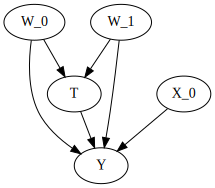

In [80]:
g = gr.Digraph()

g.edge("W_0", "T")
g.edge("W_1", "T")
g.edge("X_0", "Y")
g.edge("W_0", "Y")
g.edge("W_1", "Y")
g.edge("T", "Y")

g

На занятии мы рассмотрели пример, в котором одну из моделей заменяли на случайный шум. Рассмотрим теперь случай, в котором не вся модель заменяется на шум, а только лишь ее предсказания для $s$% элементов выборки. Рассмотрите следующую сетку значений $s$ для каждого типа модели отдельно:

```[0, 0.05, 0.1, 0.2, 0.5, 1]```

Например, нужно рассмотреть случай, в котором значений propensity score для случайных 5% объектов заменяются на шум **и** значений потенциальных исходов каждого типа для случайных 10% объектов заменяются на свой шум. Обратите внимание, что в данном примере эти 10% объектов должны совпадать для каждого типа потенциальных исходов.

Исследуйте
* смещение оценки причинно-следственного эффекта от истинного значения по метрике MAPE,
* среднюю длину доверительного интервала.

Не забывайте, что в подобных статистических исследованиях необходимо повторять эксперименты достаточно большое количество раз (несколько тысяч). Для ускорения работы и получения более стабильных результатов рекомендуется на каждой итерации один раз генерировать данные, а затем применять для них все варианты моделей.

In [81]:
def doubly_robust(df, X, T, Y, ps_noise_propotion=0, mu_noise_propotion=0):
    """
    Оценка ATE с двойной надежностью.

    * df -- таблица данных
    * X -- список имен столбцов конфаундеров
    * T -- имя тритмента
    * Y -- имя таргета
    """
    n = len(df)
    mask_ps_noise = np.random.rand(n) < ps_noise_propotion
    mask_mu_noise = np.random.rand(n) < mu_noise_propotion

    if mask_ps_noise.sum() == n:
        ps = np.random.uniform(0.1, 0.9, n)
    else:
        lr = LogisticRegression(C=1e6, max_iter=1000)
        lr.fit(df.loc[~mask_ps_noise, X], df.loc[~mask_ps_noise, T])
        ps = lr.predict_proba(df[X])[:, 1]
        ps[mask_ps_noise] = np.random.uniform(0.1, 0.9, mask_ps_noise.sum())

    df0 = df[df[T] == 0]
    df1 = df[df[T] == 1]

    if mask_mu_noise.sum() == n:
        mu0 = np.random.normal(0, 1, n)
        mu1 = np.random.normal(0, 1, n)
    else:
        model0 = LinearRegression().fit(
            df0.loc[~mask_mu_noise[df0.index], X], df0.loc[~mask_mu_noise[df0.index], Y]
        )
        model1 = LinearRegression().fit(
            df1.loc[~mask_mu_noise[df1.index], X], df1.loc[~mask_mu_noise[df1.index], Y]
        )

        mu0 = model0.predict(df[X])
        mu1 = model1.predict(df[X])
        mu0[mask_mu_noise] = np.random.normal(0, 1, mask_mu_noise.sum())
        mu1[mask_mu_noise] = np.random.normal(0, 1, mask_mu_noise.sum())

    dr1 = df[T] * (df[Y] - mu1) / ps + mu1
    dr0 = (1 - df[T]) * (df[Y] - mu0) / (1 - ps) + mu0

    return dr1.mean() - dr0.mean()

In [82]:
ps_noise_propotions = [0, 0.05, 0.1, 0.2, 0.5, 1]
mu_noise_propotions = [0, 0.05, 0.1, 0.2, 0.5, 1]
Y = "y"
T = "T"
X = ["W_0", "W_1"]
n_iter = 2000
alpha = 0.05
combos = list(product(ps_noise_propotions, mu_noise_propotions))

In [ ]:
def simulate_once(seed):
    np.random.seed(seed)

    data = generate_data(
        effect=effect,
        sample_size=sample_size,
        n_confounders=2,
        n_instruments=0,
        n_covariates=1,
    )

    out = {}
    for combo in combos:
        ps_noise, mu_noise = combo
        out[combo] = doubly_robust(
            data, X, T, Y, ps_noise_propotion=ps_noise, mu_noise_propotion=mu_noise
        )
    return out


results = Parallel(n_jobs=-1, backend="loky")(
    delayed(simulate_once)(i) for i in tqdm(range(n_iter), desc="Simulations")
)

predictions = {combo: [] for combo in combos}
for res in results:
    for combo, ate_pred in res.items():
        predictions[combo].append(ate_pred)

mape_results = {
    combo: mape([effect] * n_iter, preds) for combo, preds in predictions.items()
}

ci_length = {}
for combo, preds in predictions.items():
    ci = np.percentile(preds, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    ci_length[combo] = ci[1] - ci[0]

df_mape = pd.DataFrame(
    [(ps, mu, mape_results[(ps, mu)]) for ps, mu in combos],
    columns=["ps_noise", "mu_noise", "MAPE"],
).pivot(index="ps_noise", columns="mu_noise", values="MAPE")

df_ci_length = pd.DataFrame(
    [(ps, mu, ci_length[(ps, mu)]) for ps, mu in combos],
    columns=["ps_noise", "mu_noise", "CI_length"],
).pivot(index="ps_noise", columns="mu_noise", values="CI_length")

Simulations:   0%|          | 0/2000 [00:00<?, ?it/s]

Визуализируйте результаты наглядным способом. Проверьте себя, что в случае, когда хотя бы для одной из моделей уровень шума составляет 0%, имеет место несмещенность итоговой оценки.

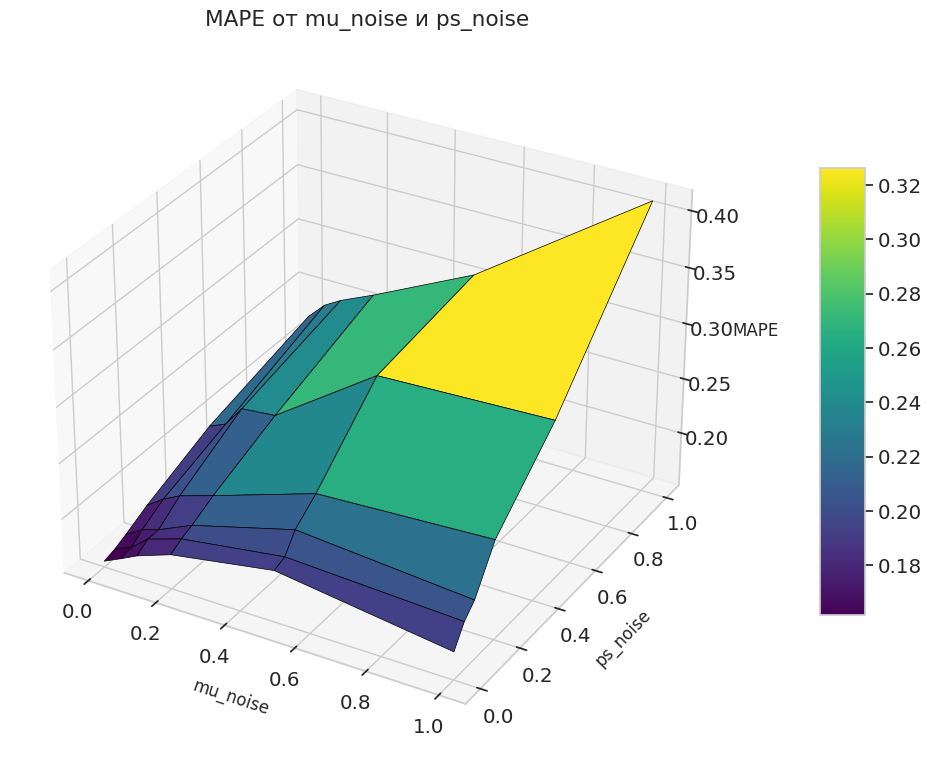

In [84]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

x, y = df_mape.columns.values, df_mape.index.values
x, y = np.meshgrid(x, y)
z = df_mape.values

surf = ax.plot_surface(x, y, z, cmap="viridis", edgecolor="k", linewidth=0.5)

ax.set_xlabel("mu_noise", labelpad=10)
ax.set_ylabel("ps_noise", labelpad=10)
ax.set_zlabel("MAPE", labelpad=10)

ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.zaxis.label.set_size(12)

fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1)

plt.title("MAPE от mu_noise и ps_noise")
plt.tight_layout()
plt.show()

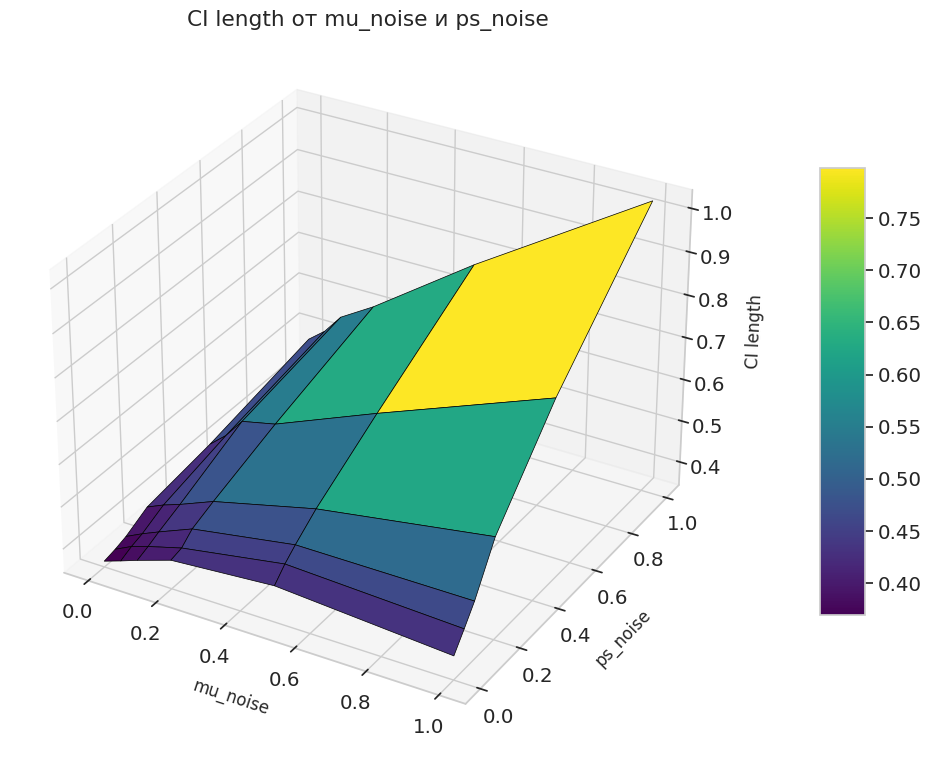

In [85]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

x, y = df_ci_length.columns.values, df_ci_length.index.values
x, y = np.meshgrid(x, y)
z = df_ci_length.values

surf = ax.plot_surface(x, y, z, cmap="viridis", edgecolor="k", linewidth=0.5)

ax.set_xlabel("mu_noise", labelpad=10)
ax.set_ylabel("ps_noise", labelpad=10)
ax.set_zlabel("CI length", labelpad=10)

ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.zaxis.label.set_size(12)

fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1)

plt.title("CI length от mu_noise и ps_noise")
plt.tight_layout()
plt.show()

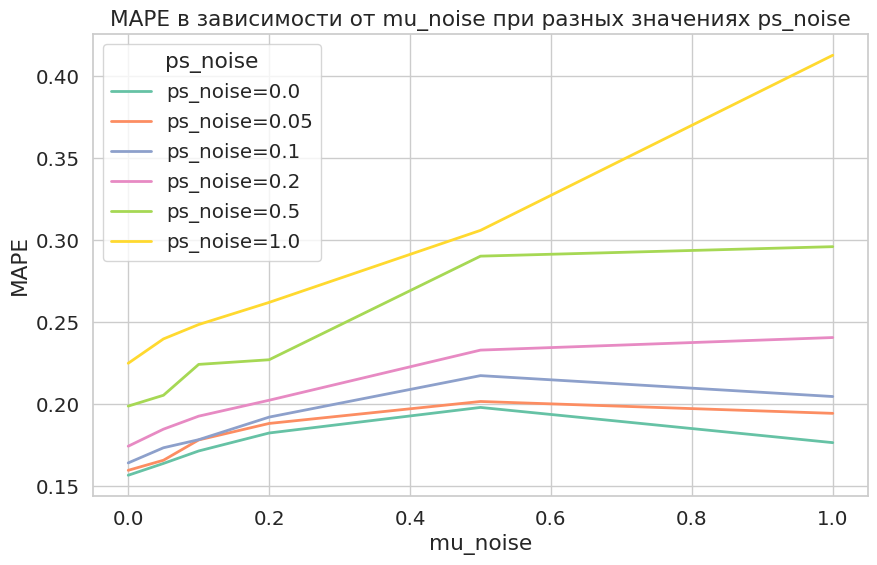

In [86]:
plt.figure(figsize=(10, 6))
for ps_noise in df_mape.index:
    plt.plot(df_mape.columns, df_mape.loc[ps_noise], label=f"ps_noise={ps_noise}", lw=2)
plt.xlabel("mu_noise")
plt.ylabel("MAPE")
plt.title("MAPE в зависимости от mu_noise при разных значениях ps_noise")
plt.legend(title="ps_noise")
plt.grid(True)
plt.show()

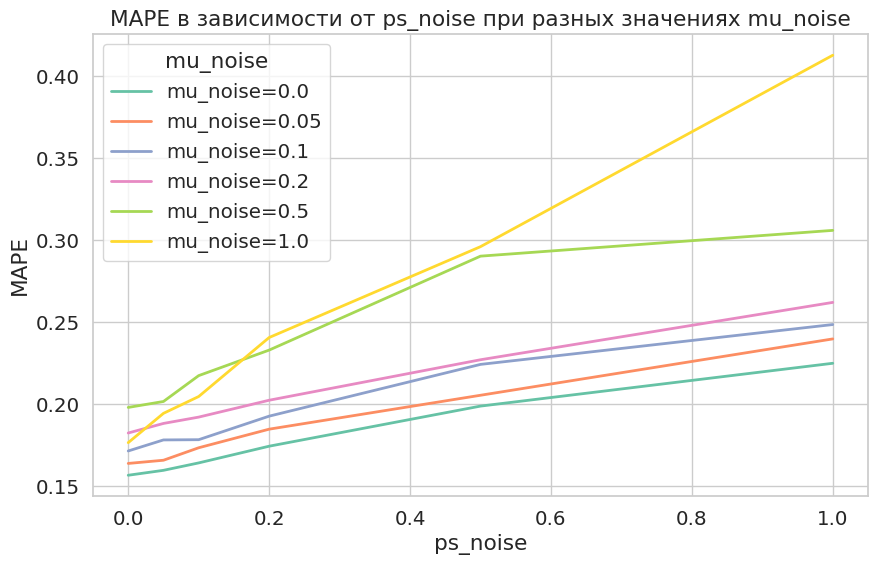

In [87]:
plt.figure(figsize=(10, 6))
for mu_noise in df_mape.columns:
    plt.plot(df_mape.index, df_mape[mu_noise], label=f"mu_noise={mu_noise}", lw=2)
plt.xlabel("ps_noise")
plt.ylabel("MAPE")
plt.title("MAPE в зависимости от ps_noise при разных значениях mu_noise")
plt.legend(title="mu_noise")
plt.grid(True)
plt.show()

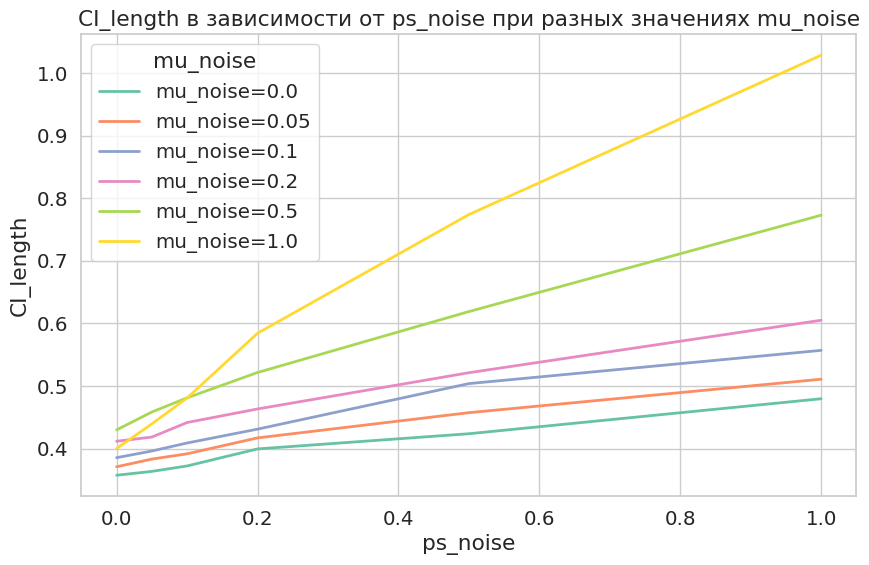

In [88]:
plt.figure(figsize=(10, 6))
for mu_noise in df_ci_length.columns:
    plt.plot(
        df_ci_length.index, df_ci_length[mu_noise], label=f"mu_noise={mu_noise}", lw=2
    )
plt.xlabel("ps_noise")
plt.ylabel("CI_length")
plt.title("CI_length в зависимости от ps_noise при разных значениях mu_noise")
plt.legend(title="mu_noise")
plt.grid(True)
plt.show()

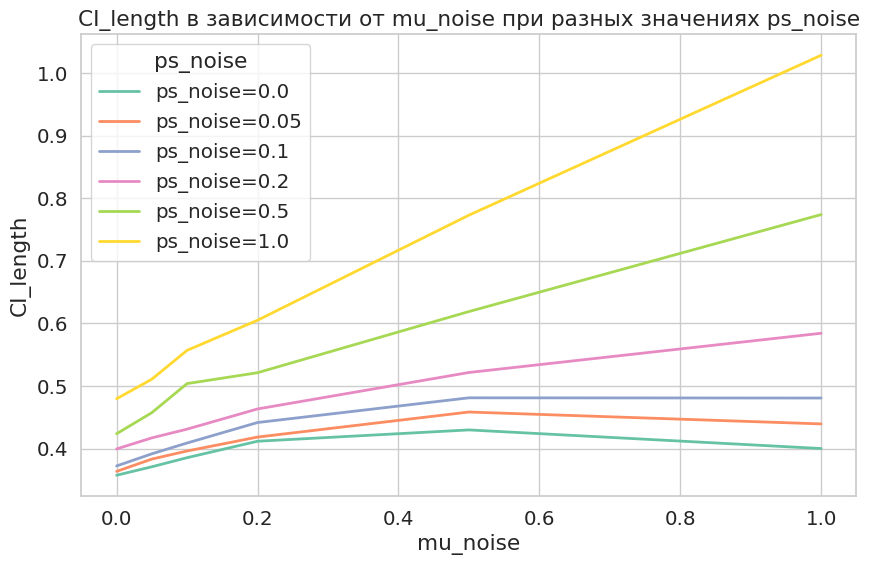

In [89]:
plt.figure(figsize=(10, 6))
for ps_noise in df_ci_length.index:
    plt.plot(
        df_ci_length.columns,
        df_ci_length.loc[ps_noise],
        label=f"ps_noise={ps_noise}",
        lw=2,
    )
plt.xlabel("mu_noise")
plt.ylabel("CI_length")
plt.title("CI_length в зависимости от mu_noise при разных значениях ps_noise")
plt.legend(title="ps_noise")
plt.grid(True)
plt.show()

**Выводы:** 

Мы видим, что MAPE растет особенно быстро при одновременном увеличении шума для средних и propensity score

Аналогично можно сказать про среднюю длину доверительно интервала.

Заметим, что график средней длины доверительного интервала более гладкий чем у MAPE

---
### Задача 2.

Рассмотрим следующие метрики ошибки/качества моделей оценки причинно-следственного вывода, которые также оценивают доверительный интервал эффекта, тем самым позволяя проверить гипотезу об отсутствии причинно-следственного эффекта.
1. Вероятность отвержения гипотезы об отсутствии эффекта, что в зависимости от отсутствия/наличии эффекта соответствует вероятности ошибки 1 рода и мощность соответственно.
2. MAPE &mdash; математическое ожидание модуля относительного отклонения оценки эффекта от его истинного значения.
3. Вероятность покрытия доверительным интервалов параметра &mdash; вероятность того, что доверительный интервал накрывает истинное значение эффекта.
4. Длина доверительного интервала.

Каждую из этих метрик можно оценить с помощью многократного семплирования данных подобно итерациям AA-тестования. Реализуйте по шаблону функции для вычисления этих метрик, имея на входе результаты семплирований. 

*Примечание.* Для некоторых метрик могут потребоваться не все аргументы, но для универсальности сигнатуры оставляйте их всех. Так будет удобнее в дальнейшем реализовывать саму процедуру валидации, сделав цикл по всем метрикам.

In [90]:
def metric_power(estimations, left, right, true_effect=0):
    """
    Вероятность отвержения гипотезы H0: theta = 0.
    Если true_effect == 0, метрика измеряет вероятность ошибки I рода.
    Если true_effect != 0, метрика измеряет мощность.

    estimations -- массив оценок причинно-следственного эффекта
    left, right -- массивы для левой и правой границ доверительного
                   интервала причинно-следственного эффекта
    true_effect -- истинное значение причинно-следственного эффекта (по умолчанию 0)
    """
    rejected = (0 < left) | (0 > right)  # т.е. 0 не входит в CI
    return rejected.mean()


def metric_mape(estimations, left, right, true_effect=0):
    if true_effect == 0:
        raise ValueError("MAPE не определён при true_effect = 0")
    true_effect_array = np.full_like(estimations, true_effect, dtype=float)
    return mape(true_effect_array, estimations)


def metric_coverage(estimations, left, right, true_effect=0):
    covered = (left <= true_effect) & (right >= true_effect)
    return covered.mean()


def metric_length(estimations, left, right, true_effect=0):
    return (right - left).mean()

Сначала проведем базовую валидацию моделей на искусственных данных. Для генерации используйте функцию из ноутбука по валидации с CI, генерируя следующие варианты данных:
1. имеется только тритмент и таргет,
2. добавляются ковариаты,
3. добавляются конфаундеры.

Проведите сравнение следующих моделей:
* [данные 1-3] **Обычный t-test**, варианты применения
    * простая реализация из `scipy`
    * использование линейной регрессии из `statsmodels`
    * использование `backdoor.linear_regression` в `dowhy`, в которую передать только *тритмент и таргет*;
* [данные 2-3] **CUPED**, варианты применения
    * функции из прошлых ноутбуков
    * использование линейной регрессии из `statsmodels`
    * использование `backdoor.linear_regression` в `dowhy`, в которую передать только *тритмент, таргет и ковариаты*;
* [данные 3] **Propensity Score Weighting**, варианты применения
    * функции из прошлых ноутбуков, используя вариант с линейной регрессией *без* ковариат и конфаундеров
    * использование `backdoor.propensity_score_weighting` в `dowhy`, в которую передать *тритмент, таргет, ковариаты и конфаундеры*;
* [данные 3] **Doubly Robust Estimation**, варианты применения
    * функции из прошлых ноутбуков, используя вариант с линейной регрессией *с* ковариатами и конфаундерами
    * использование `backdoor.econml.dr.LinearDRLearner` в `dowhy`, в которую передать *тритмент, таргет, ковариаты и конфаундеры*;


Каждое значение метрики необходимо вычислять на данных с одинаковыми статистическими свойствами (связи, количество признаков, размер данных, и т.д.). Тем самым пайплайн валидации **одной** модели на **одной** структуре данных должен быть примерно следующим.

```
- Фиксация структуры данных (связи, количество признаков, размер данных, ...)
- Итерации метода Монте-Карло:
    * Генерация семпла данных, все опции фиксированы
    * Обучение модели, оценка эффекта, построение интервала
    * Сохранение результатов
- Вычисление значений метрик. Здесь мы получаем одну оценку каждой метрики для фиксированной структуры данных.
```

Все методы стоит проверять на одних тех же данных.
Во-первых, это экономит время за счет меньшего количества семплирований, а во-вторых, результаты будут обладать большей стабильностью в контексте сравнения моделей, ведь мы будем сравнивать модели на одинаковых данных. Тем самым пайплайн валидации **всех** моделей на **одной** структуре данных должен быть примерно следующим.

```
- Фиксация структуры данных (связи, количество признаков, размер данных, ...)
- Итерации метода Монте-Карло:
    * Генерация семпла данных, все опции фиксированы
    * Для каждой исследуемой модели:
        - Обучение модели, оценка эффекта, построение интервала
        - Сохранение результатов
- Для каждой исследуемой модели:
    * Вычисление значений метрик. Здесь мы получаем одну оценку каждой метрики для фиксированной структуры данных.
```

Количество итераций Монте-Карло должно быть не менее $10^3$. Размер данных возьмите равными $10^3$. Для ускорения можно использовать распараллеливание (см., например, ноутбук по doubly robust estimation). <b><u>Тестируйте свой код на малом количестве итераций.</u></b>

In [91]:
def causal_model_test(
    data,
    names_dict=defaultdict(list, {"treatment": "T", "target": "y"}),
    method="backdoor.propensity_score_weighting",
    alpha=0.05,
    bs_sims=2,             # ← Новое: число бутстрэп-репликаций
    bs_frac=1.0,             # ← Новое: доля подвыборки в каждой репликации
):
    """
    Применяет метод оценки причинного эффекта с использованием DoWhy.

    Параметры
    ----------
    data: pd.DataFrame
        Данные с колонками: treatment, target, confounders, instruments, covariates
    names_dict: defaultdict(list)
        Словарь с именами переменных (ключи: "treatment", "target", "confounders", "instruments", "covariates")
    method: str
        Метод DoWhy для оценки эффекта, например: "backdoor.linear_regression"
    alpha: float
        Уровень значимости (1 - уровень доверия)
    bs_sims: int
        Число бутстрэп-репликаций для оценки доверительных интервалов
    bs_frac: float
        Доля исходной выборки, используемой в каждой бутстрэп-репликации

    Возвращает
    ----------
    estimation: float
        Оценка эффекта
    left_bound: float
        Левая граница доверительного интервала (если возможно, иначе np.nan)
    right_bound: float
        Правая граница доверительного интервала (если возможно, иначе np.nan)
    """
    # объявляем модель
    model = CausalModel(
        data=data,
        treatment=names_dict["treatment"],
        outcome=names_dict["target"],
        common_causes=names_dict["confounders"],
        instruments=names_dict["instruments"],
        effect_modifiers=names_dict["covariates"],
    )

    # идентификация
    identified_estimand = model.identify_effect()

    # параметры метода
    if method.startswith("backdoor.econml"):
        method_spec = {
            "init_params": {
                "model_propensity": "linear",
                "model_regression": "linear",
            },
            "fit_params": {"inference": "bootstrap"},
            "num_simulations": bs_sims,
            "sample_size_fraction": bs_frac,
        }
    else:
        method_spec = {
            "num_simulations": bs_sims,
            "sample_size_fraction": bs_frac,
        }

    # оценка эффекта
    estimate = model.estimate_effect(
        identified_estimand,
        method_name=method,
        method_params=method_spec,
        confidence_intervals="bootstrap",
    )

    estimation = estimate.value

    # попытка получить доверительный интервал
    try:
        ci = estimate.get_confidence_intervals(confidence_level=1 - alpha)
        left_bound, right_bound = np.squeeze(ci)
    except Exception:
        left_bound, right_bound = np.nan, np.nan

    return estimation, left_bound, right_bound


In [92]:
n_iter = 1000
effect = 0.05
sample_size = 1000
jobs = -1

In [93]:
models_results = {
    "vanila_ttest": {"estimations": [], "ci": []},
    "statsmodels": {"estimations": [], "ci": []},
    "dowhy": {"estimations": [], "ci": []},
}
configs = [
    {
        "effect": effect,
        "sample_size": sample_size,
        "n_confounders": 0,
        "n_instruments": 0,
        "n_covariates": 0,
    },  # только тритмент и таргет
    {
        "effect": effect,
        "sample_size": sample_size,
        "n_confounders": 0,
        "n_instruments": 0,
        "n_covariates": 2,
    },  # только тритмент, таргет и 2 ковариаты
    {
        "effect": effect,
        "sample_size": sample_size,
        "n_confounders": 2,
        "n_instruments": 0,
        "n_covariates": 2,
    },  # только тритмент, таргет, 2 ковариаты и 2 конфаундера
]

config_variable_names = [
    {
        "treatment": "T",
        "target": "y",
        "confounders": [],
        "instruments": [],
        "covariates": [],
    },
    {
        "treatment": "T",
        "target": "y",
        "covariates": ["X_0", "X_1"],
        "confounders": [],
        "instruments": [],
    },
    {
        "treatment": "T",
        "target": "y",
        "covariates": ["X_0", "X_1"],
        "confounders": ["W_0", "W_1"],
        "instruments": [],
    },
]


In [94]:
def process_iteration(cfg_idx, name, names_dict, method, cfg):
    """Обрабатывает одну итерацию симуляции"""
    data = generate_data(**cfg)
    est, lb, rb = causal_model_test(data, 
                                   names_dict=names_dict,
                                   method=method)
    return {
        "config": cfg_idx,
        "model": name,
        "estimate": est,
        "ci_low": lb,
        "ci_high": rb,
    }

raw = []
model_specs = [
    ("T‑test DoWhy‑LR",      config_variable_names[0], "backdoor.linear_regression"),
    ("CUPED DoWhy‑LR",       config_variable_names[1], "backdoor.linear_regression"),
    ("PSW DoWhy‑PSW",        config_variable_names[2], "backdoor.propensity_score_weighting"),
    ("DR DoWhy‑DRLearner",   config_variable_names[2], "backdoor.econml.dr.LinearDRLearner"),
]

for cfg_idx, cfg in enumerate(configs):
    for name, names_dict, method in model_specs:
        # Фильтрация конфигураций (сохраняем оригинальную логику)
        if cfg_idx == 0 and name != "T‑test DoWhy‑LR":
            continue
        if cfg_idx == 1 and name not in ("T‑test DoWhy‑LR", "CUPED DoWhy‑LR"):
            continue
        
        tasks = (delayed(process_iteration)(cfg_idx, name, names_dict, method, cfg)
                 for _ in range(n_iter))
        
        results = Parallel(n_jobs=jobs, verbose=0)(
            tqdm(tasks, 
                 desc=f"Config {cfg_idx} → {name}", 
                 total=n_iter)
        )
        
        raw.extend(results)

Config 0 → T‑test DoWhy‑LR:   0%|          | 0/1000 [00:00<?, ?it/s]

Config 1 → T‑test DoWhy‑LR:   0%|          | 0/1000 [00:00<?, ?it/s]

Config 1 → CUPED DoWhy‑LR:   0%|          | 0/1000 [00:00<?, ?it/s]

Config 2 → T‑test DoWhy‑LR:   0%|          | 0/1000 [00:00<?, ?it/s]

Config 2 → CUPED DoWhy‑LR:   0%|          | 0/1000 [00:00<?, ?it/s]

Config 2 → PSW DoWhy‑PSW:   0%|          | 0/1000 [00:00<?, ?it/s]

Config 2 → DR DoWhy‑DRLearner:   0%|          | 0/1000 [00:00<?, ?it/s]

Предположим, что некоторые конфаундеры ненаблюдаемы, но они существуют. То есть их нужно сгенерировать, но не передавать в модель. Возможно, проще будет воспользоваться интерфейсом через указание типов переменных.

Провалидируйте модель Propensity Score Weighting. Сравните результаты. Чем нам мешают ненаблюдаемые конфаундеры?

Будем использовать 2-й конфиг со словарем, где указан 1 конфаундер

In [95]:
config_variable_name = {
    "treatment": "T",
    "target": "y",
    "covariates": ["X_0", "X_1"],
    "confounders": ["W_0"],
    "instruments": [],
}

In [96]:
model_specs = [(
    "PSW DoWhy‑PSW, the confounder isn't specified",
    config_variable_name,
    "backdoor.propensity_score_weighting",
)]


tasks = (
    delayed(process_iteration)(2, model_specs[0][0], model_specs[0][1], model_specs[0][2], configs[2])
    for _ in range(n_iter)
)

results = Parallel(n_jobs=jobs, verbose=0)(
    tqdm(tasks, desc=f"Config 2 → {model_specs[0][0]}", total=n_iter)
)

raw.extend(results)

Config 2 → PSW DoWhy‑PSW, the confounder isn't specified:   0%|          | 0/1000 [00:00<?, ?it/s]

In [97]:
def compute_group_metrics(g):
    est = g["estimate"].values
    lb = g["ci_low"].values
    rb = g["ci_high"].values
    return pd.Series(
        {
            "power": round(metric_power(est, lb, rb, true_effect=effect), 3),
            "coverage": round(metric_coverage(est, lb, rb, true_effect=effect), 3),
            "length": round(metric_length(est, lb, rb, true_effect=effect), 3),
            **(
                {"mape": round(metric_mape(est, lb, rb, true_effect=effect), 3)}
                if effect != 0
                else {}
            ),
        }
    )

df = pd.DataFrame(raw)
metrics_df = df.groupby(["config", "model"]).apply(compute_group_metrics).reset_index()

metrics_df

,config,model,power,coverage,length,mape
0,0,T‑test DoWhy‑LR,0.735,0.295,0.069,0.995
1,1,CUPED DoWhy‑LR,0.710,0.310,0.087,1.226
2,1,T‑test DoWhy‑LR,0.692,0.326,0.123,1.677
3,2,CUPED DoWhy‑LR,0.781,0.310,0.134,2.270
4,2,DR DoWhy‑DRLearner,0.739,0.322,0.070,0.993
5,2,PSW DoWhy‑PSW,0.649,0.376,0.151,1.768
6,2,"PSW DoWhy‑PSW, the confounder isn't specified",0.672,0.351,0.165,2.100
7,2,T‑test DoWhy‑LR,0.744,0.300,0.160,2.706


Какие методы оказались лучше?

**Выводы:** 

Видим, что все методы показали схожую мощность, кроме Propensity Score Weighting, который на 2 конфиге показал худшую мощность. 

Самым мощным, на удивление, оказался обычный t-test, хоть и не значительно. Тем не менее он имеет огромную ошибку MAPE.

Если судить по MAPE то лучшим оказался Doubly Robust Estimation

Propensity Score Weighting без указания конфаундера показал большую мощность, чем с указаным конфаундером, но при это меньшее покрытие и болшее MAPE.